In [1]:
import polars as pl
import seaborn as sns
from util import query_wdqs
import scipy.stats as stats
from numpy.polynomial import Polynomial
from sklearn.metrics import r2_score


sns.set_theme(
    font_scale=1.00,
    rc={"figure.figsize": (7, 4), "figure.autolayout": True, "figure.dpi": 300},
)


books_1001 = pl.read_csv("1001-books-plus-wikidata.tsv", separator="\t")

## Data enrichment

In [2]:
# Create a sitelinks dataframe work works and authors
# Columns: qid, sitelink, edition

# Extract unique Wikidata IDs
work_qids = books_1001["Work Wikidata ID"].unique().to_list()
author_qids = books_1001["Author Wikidata ID"].unique().to_list()
qids = work_qids + author_qids

# Query with '%s' placeholder for the work QIDs
sitelinks_query = """
SELECT DISTINCT ?qid ?sitelink WHERE {
    VALUES ?qid {
        %s
    }

    OPTIONAL {
        ?sitelink schema:about ?qid.
    }

    FILTER(CONTAINS(STR(?sitelink), ".wikipedia.org/"))
}
"""

sitelinks = (
    query_wdqs(sitelinks_query, qids)
    .with_columns(
        edition=pl.col("sitelink").str.extract(r"([\w-]+).wikipedia.org"),
    )
    .drop_nulls("sitelink")
    # Sort for easier diffing
    .sort(pl.col("qid").str.slice(1).cast(pl.Int64), "sitelink")
)

sitelinks.write_csv("outputs/sitelinks.tsv", separator="\t")
sitelinks

Request took 0.725933 seconds.


qid,sitelink,edition
str,str,str
"""Q42""","""https://af.wikipedia.org/wiki/…","""af"""
"""Q42""","""https://ar.wikipedia.org/wiki/…","""ar"""
"""Q42""","""https://arz.wikipedia.org/wiki…","""arz"""
"""Q42""","""https://ast.wikipedia.org/wiki…","""ast"""
"""Q42""","""https://az.wikipedia.org/wiki/…","""az"""
…,…,…
"""Q123358176""","""https://en.wikipedia.org/wiki/…","""en"""
"""Q123501462""","""https://en.wikipedia.org/wiki/…","""en"""
"""Q125217109""","""https://az.wikipedia.org/wiki/…","""az"""


In [3]:
# Count sitelinks per QID
sitelinks_agg = (
    sitelinks.group_by("qid")
    .agg(sitelinks_n=pl.len())
    .sort("sitelinks_n", descending=True)
)

sitelinks_agg

qid,sitelinks_n
str,u32
"""Q5879""",186
"""Q7243""",182
"""Q535""",176
"""Q5682""",176
"""Q991""",173
…,…
"""Q13036211""",1
"""Q2604674""",1
"""Q3286482""",1


In [4]:
qrank = pl.read_csv("inputs/qrank_2024-03-16.csv.gz")

# Join QRank and sitelinks into relevance dataframe
relevance_df = (
    books_1001
    # Join work QRank
    .join(
        qrank, left_on="Work Wikidata ID", right_on="Entity", how="left", coalesce=True
    )
    .rename({"QRank": "Work QRank"})
    # Join author QRank
    .join(
        qrank,
        left_on="Author Wikidata ID",
        right_on="Entity",
        how="left",
        coalesce=True,
    )
    .rename({"QRank": "Author QRank"})
    # Join work sitelinks
    .join(
        sitelinks_agg,
        left_on="Work Wikidata ID",
        right_on="qid",
        how="left",
        coalesce=True,
    )
    .rename({"sitelinks_n": "Work Sitelinks"})
    # Join author sitelinks
    .join(
        sitelinks_agg,
        left_on="Author Wikidata ID",
        right_on="qid",
        how="left",
        coalesce=True,
    )
    .rename({"sitelinks_n": "Author Sitelinks"})
    # Fill nulls for sitelink columns
    .with_columns(pl.col("^.*Sitelinks$").fill_null(0))
)

relevance_df.write_csv("outputs/1001-books-plus-relevance.tsv", separator="\t")
relevance_df

ID,2006 list,2008 list,2010 list,2012 list,2018 list,r/tbr/w,Book Title,Author,List,Original/Alt Title,Wilson score,nationality,Period,List Notes,Work Wikidata ID,Author Wikidata ID,Work QRank,Author QRank,Work Sitelinks,Author Sitelinks
i64,i64,i64,i64,i64,i64,str,str,str,str,str,i64,str,str,str,str,str,i64,i64,u32,u32
1,2006,null,null,null,null,null,"""Aesop’s Fables""","""Aesopus""","""2) Deleted 2008""",null,174,"""Greek""","""pre-1700s""",null,"""Q865902""","""Q43423""",871410,1246432,52,100
2,2006,null,null,null,null,null,"""Metamorphoses""","""Ovid""","""2) Deleted 2008""",null,368,"""Roman""","""pre-1700s""",null,"""Q184742""","""Q7198""",868100,1059672,61,134
3,2006,null,null,null,null,null,"""Chaireas and Kallirhoe""","""Chariton""","""2) Deleted 2008""",null,1136,null,"""pre-1700s""",null,"""Q2972092""","""Q434567""",17972,13562,10,23
4,2006,null,null,null,null,null,"""An Ethiopian Romance""","""Heliodorus""","""2) Deleted 2008""","""Aithiopika""",1164,"""Syrian""","""pre-1700s""",null,"""Q2657860""","""Q313011""",26599,25414,12,30
5,2006,2008,2010,2012,2018,null,"""The Thousand and One Nights""","""Anonymous""","""1) core list""",null,525,"""Arabian""","""pre-1700s""",null,"""Q8258""","""Q4233718""",3015976,61352,130,9
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1314,null,null,null,null,2018,null,"""H(A)PPY""","""Barker, Nicola""","""9) Added 2018""",null,1233,"""English""","""2000s""",null,null,"""Q523406""",null,7075,0,8
1315,null,null,null,null,2018,null,"""Winter""","""Smith, Ali""","""9) Added 2018""",null,421,"""Scottish""","""2000s""",null,"""Q103936491""","""Q468523""",6925,83427,2,33
1316,null,null,null,2012,2018,null,"""Gentlemen Prefer Blondes""","""Loos, Anita""","""7) Added 2012*""",null,null,"""American""","""1900s""","""* in some editions""","""Q1248760""","""Q272088""",33514,61239,7,27


In [5]:
# Get publcation year for all items
qids = books_1001["Work Wikidata ID"].unique().to_list()

pubdate_query = """
SELECT DISTINCT ?item ?pubdate WHERE {
    VALUES ?item {
        %s
    }

    ?item wdt:P577 ?pubdate.
}
"""

pubdates = (
    query_wdqs(pubdate_query, qids)
    .with_columns(pubdate=pl.col("pubdate").str.slice(0, 4).cast(pl.Int32))
    .group_by("item")
    .agg(pl.col("pubdate").min()) # Use the earliest publication date
    .sort("pubdate")
)
pubdates

Request took 0.508298 seconds.


item,pubdate
str,i32
"""Q2657860""",300
"""Q70806""",1350
"""Q70827""",1400
"""Q559667""",1490
"""Q452075""",1508
…,…
"""Q19364452""",2014
"""Q19902675""",2014
"""Q16385288""",2016


## Statistics

In [6]:
# Spearman’s rank correlation coefficient for Work QRank and Work Sitelinks
for var in ["Work", "Author"]:
    variables = [f"{var} QRank", f"{var} Sitelinks"]
    a, b = relevance_df.unique(f"{var} Wikidata ID").drop_nulls(variables)[*variables]
    print(f"Spearman’s rank correlation coefficient: {var} QRank and {var} Sitelinks")
    print(stats.spearmanr(a, b))
    print()

Spearman’s rank correlation coefficient: Work QRank and Work Sitelinks
SignificanceResult(statistic=np.float64(0.8934667908138467), pvalue=np.float64(0.0))

Spearman’s rank correlation coefficient: Author QRank and Author Sitelinks
SignificanceResult(statistic=np.float64(0.9005827512931741), pvalue=np.float64(2.2208194729276596e-279))



In [7]:
# Quadratic regression for QRank and Sitelinks (works and authors)
for var in ["Work", "Author"]:
    x, y = relevance_df.drop_nulls([f"{var} Sitelinks", f"{var} QRank"])[
        f"{var} Sitelinks", f"{var} QRank"
    ]
    model = Polynomial.fit(x, y, 2)

    r2 = r2_score(y, model(x))
    print(f"{var} QRank = {model} (R² = {r2})")
    print(f"R² = {r2}")
    print()

Work QRank = 1638179.80955728 + 2518920.5410081·(-1.0 + 0.01538462x) +
828663.28110151·(-1.0 + 0.01538462x)² (R² = 0.7179315495859606)
R² = 0.7179315495859606

Author QRank = 1282213.35656179 + 2665943.46881162·(-1.01081081 + 0.01081081x) +
1438028.96907571·(-1.01081081 + 0.01081081x)² (R² = 0.7352054644517598)
R² = 0.7352054644517598



## Plots

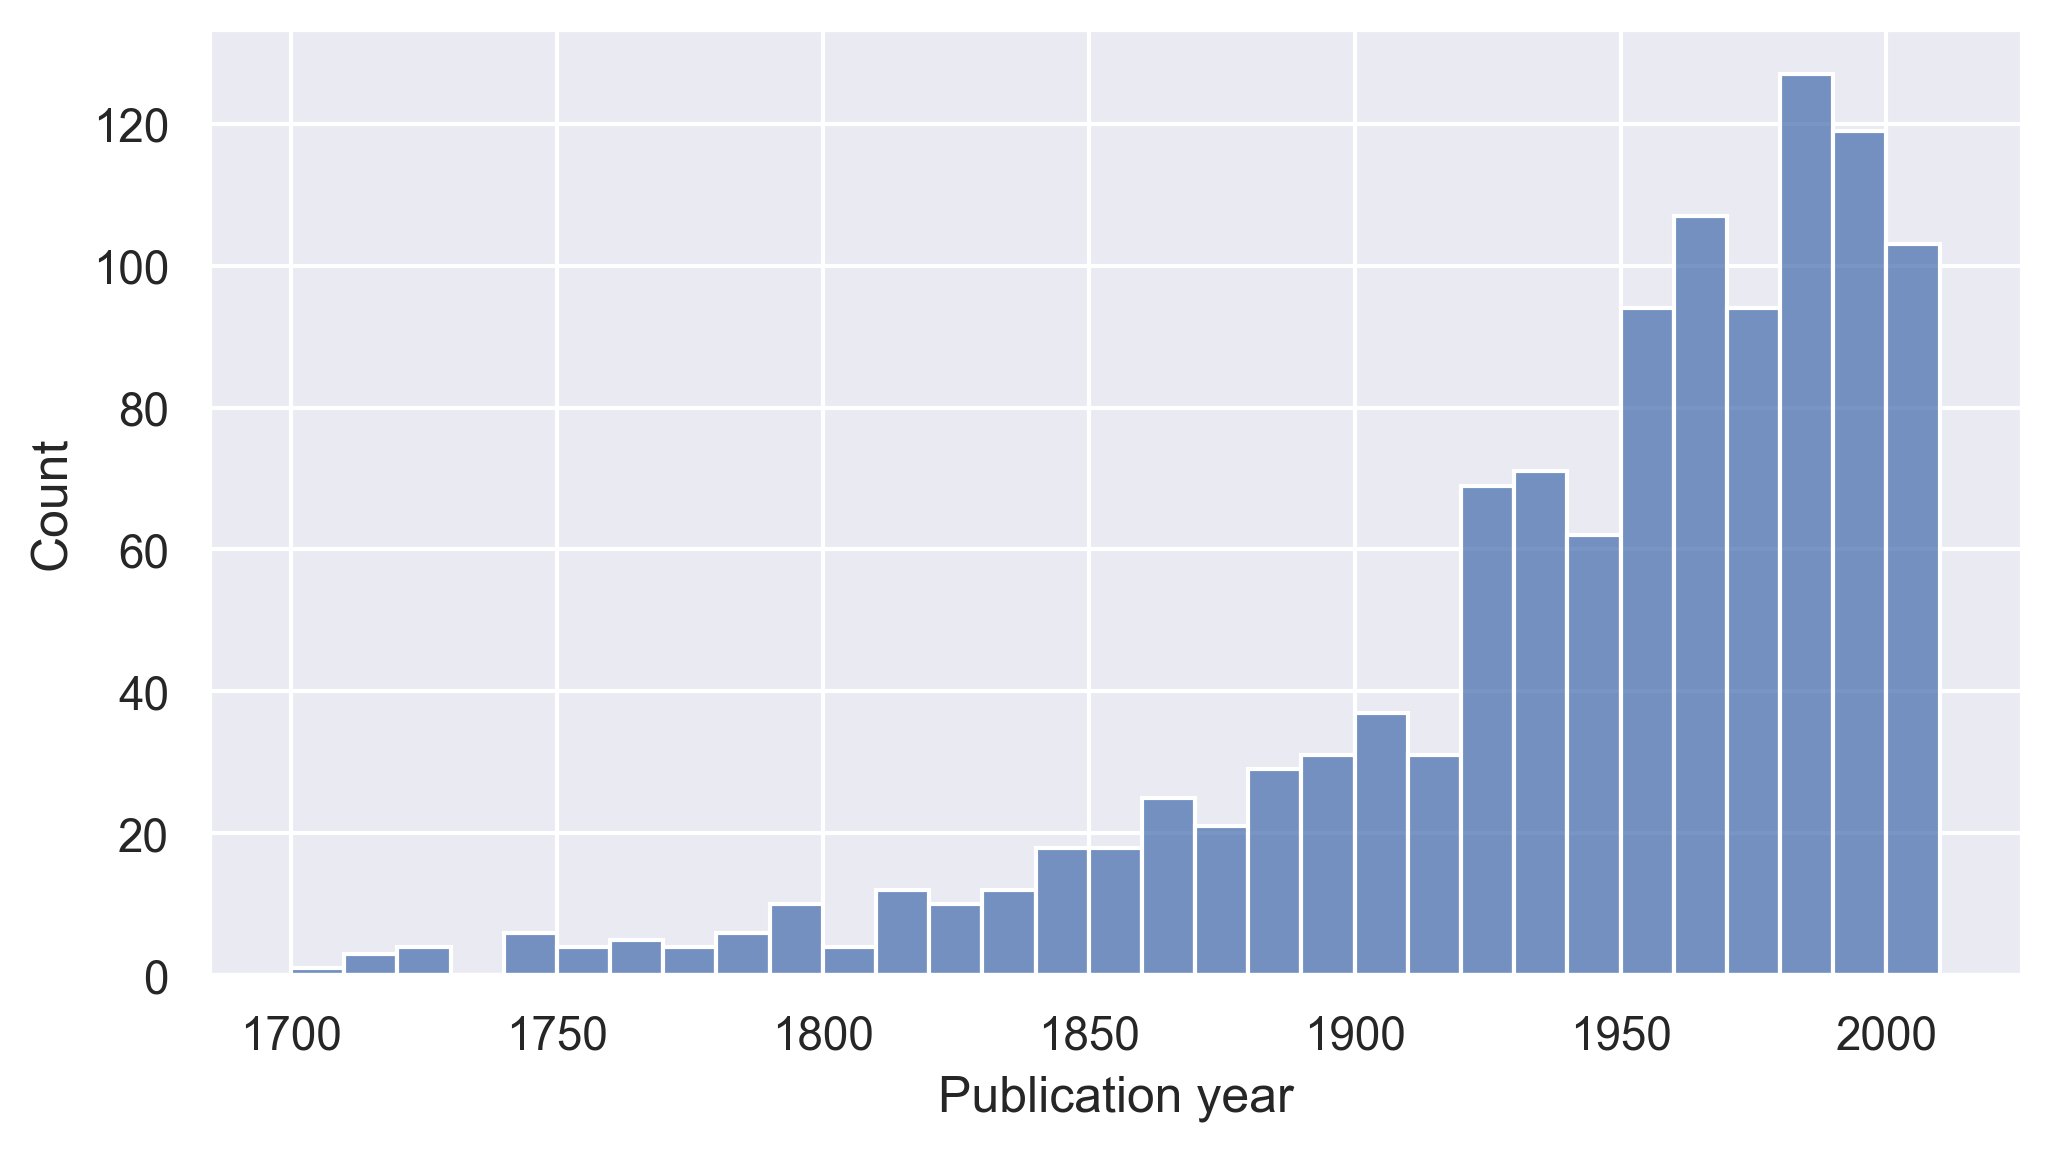

In [8]:
# Histogram of publication years
ax = sns.histplot(
    pubdates.rename({"pubdate": "Publication year"}),
    x="Publication year",
    bins=range(1700, 2020, 10)
)

n = 1318


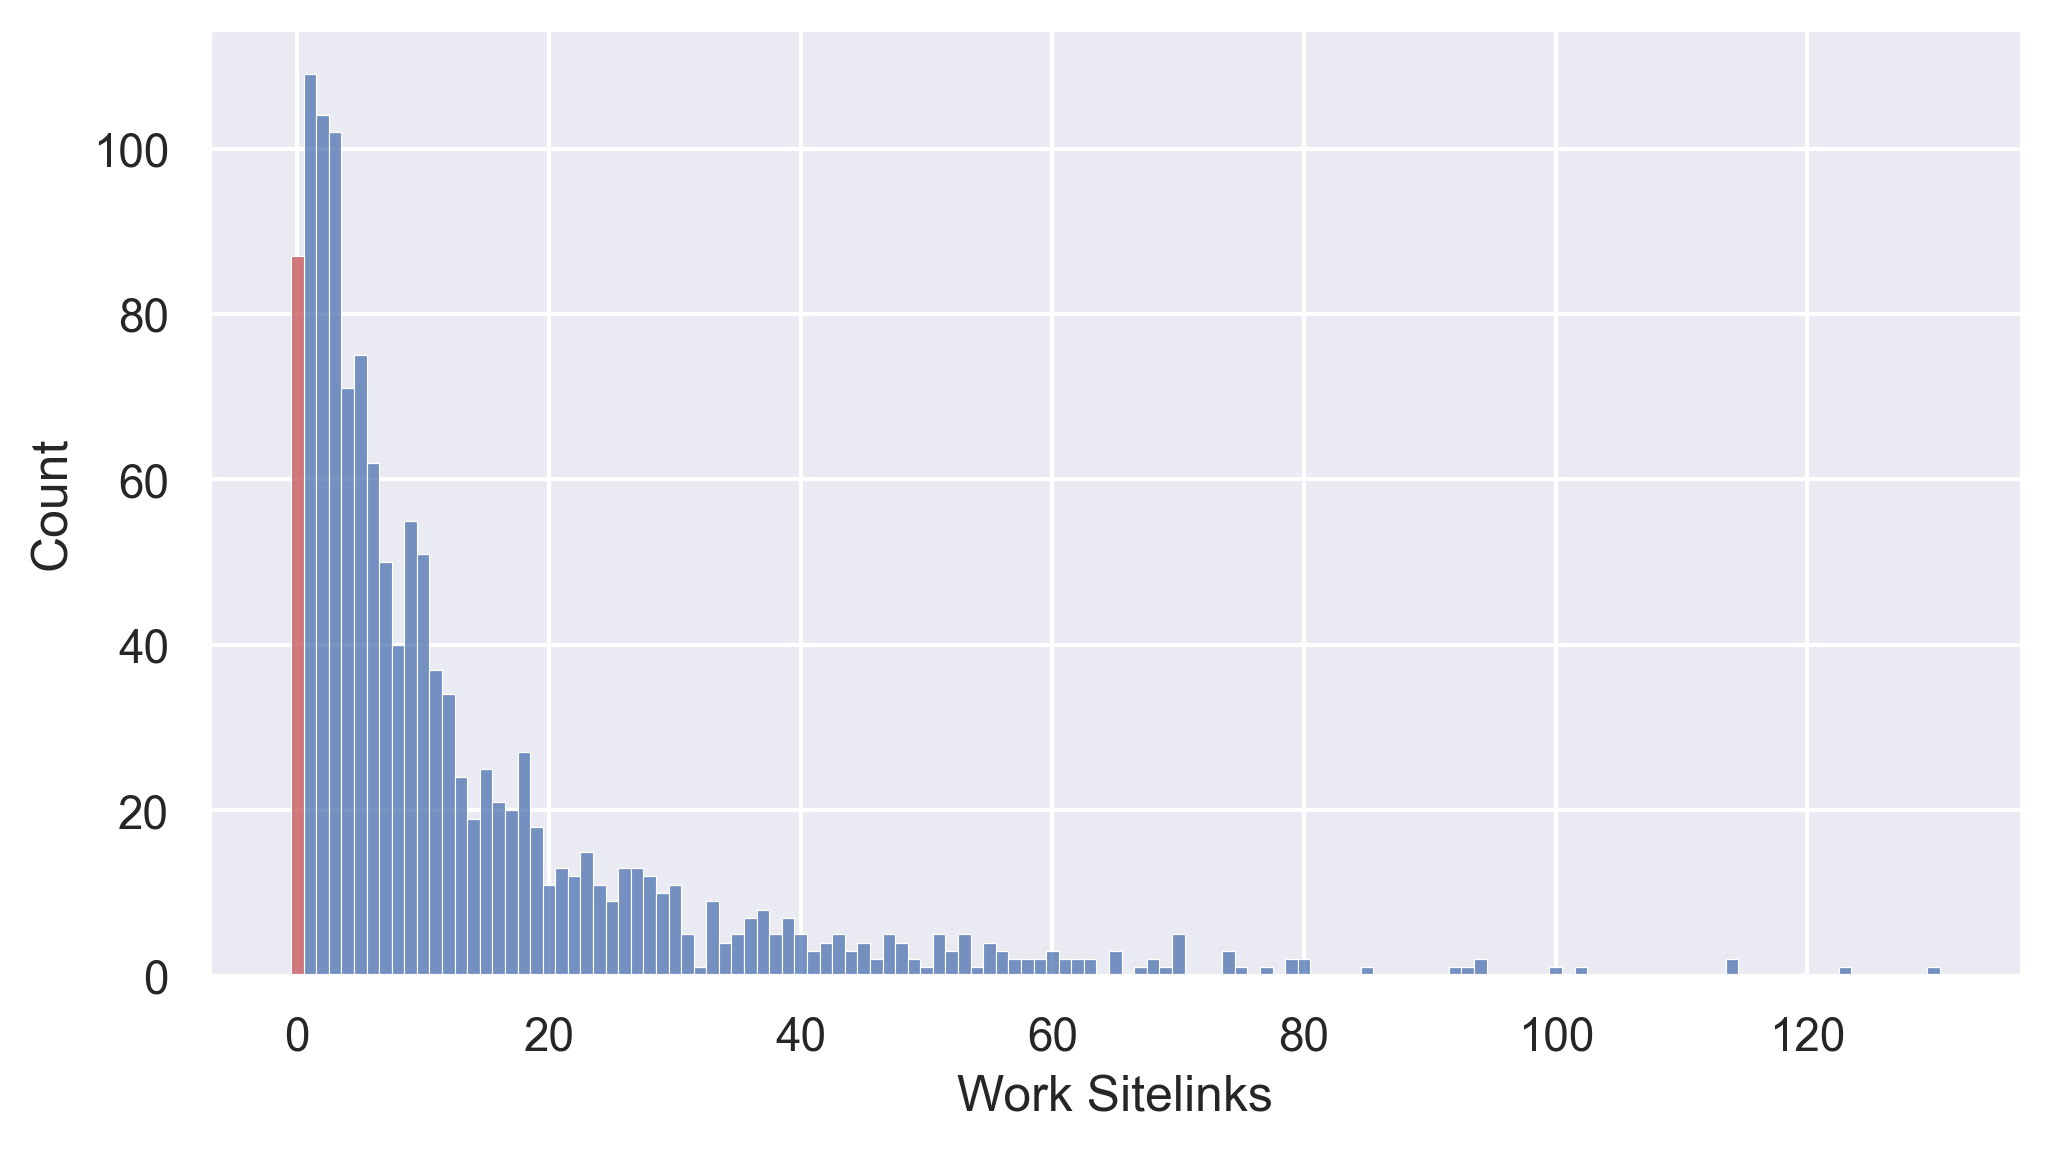

In [9]:
# Histogram of number of sitelinks for works
plot_df = relevance_df.drop_nulls("Work Sitelinks").with_columns(
    has_sitelinks=pl.col("Work Sitelinks") > 0
)
sns.histplot(
    plot_df,
    x="Work Sitelinks",
    discrete=True,
    hue="has_sitelinks",
    multiple="stack",
    palette=["r", "b"],
    legend=False,
)

print(f"n = {plot_df.height}")

n = 768


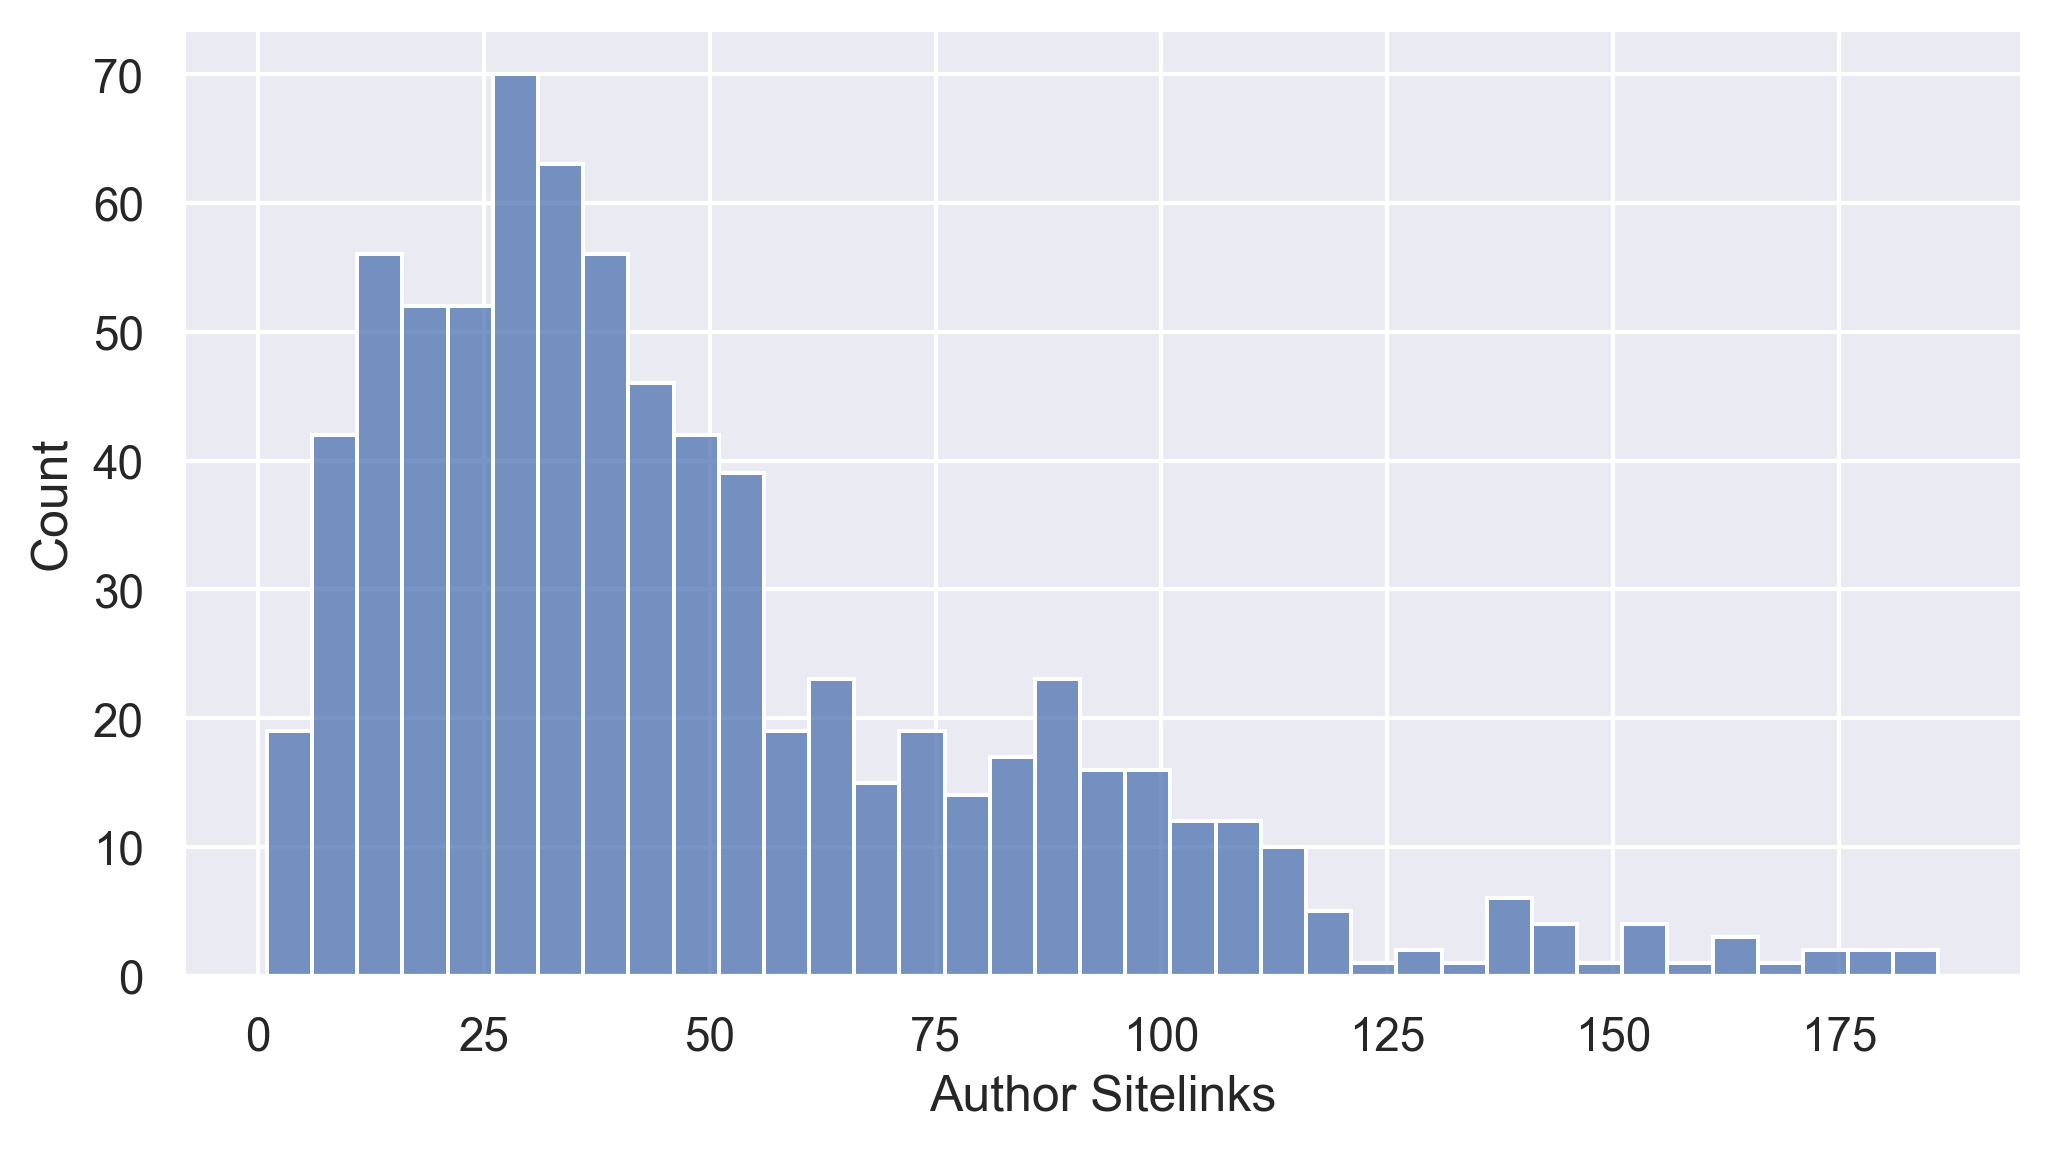

In [10]:
# Histogram of number of sitelinks for authors
plot_df = relevance_df.unique("Author Wikidata ID").drop_nulls("Author Sitelinks")
ax = sns.histplot(
    plot_df,
    x="Author Sitelinks",
    binwidth=5
)

print(f"n = {plot_df.height}")

n = 1230


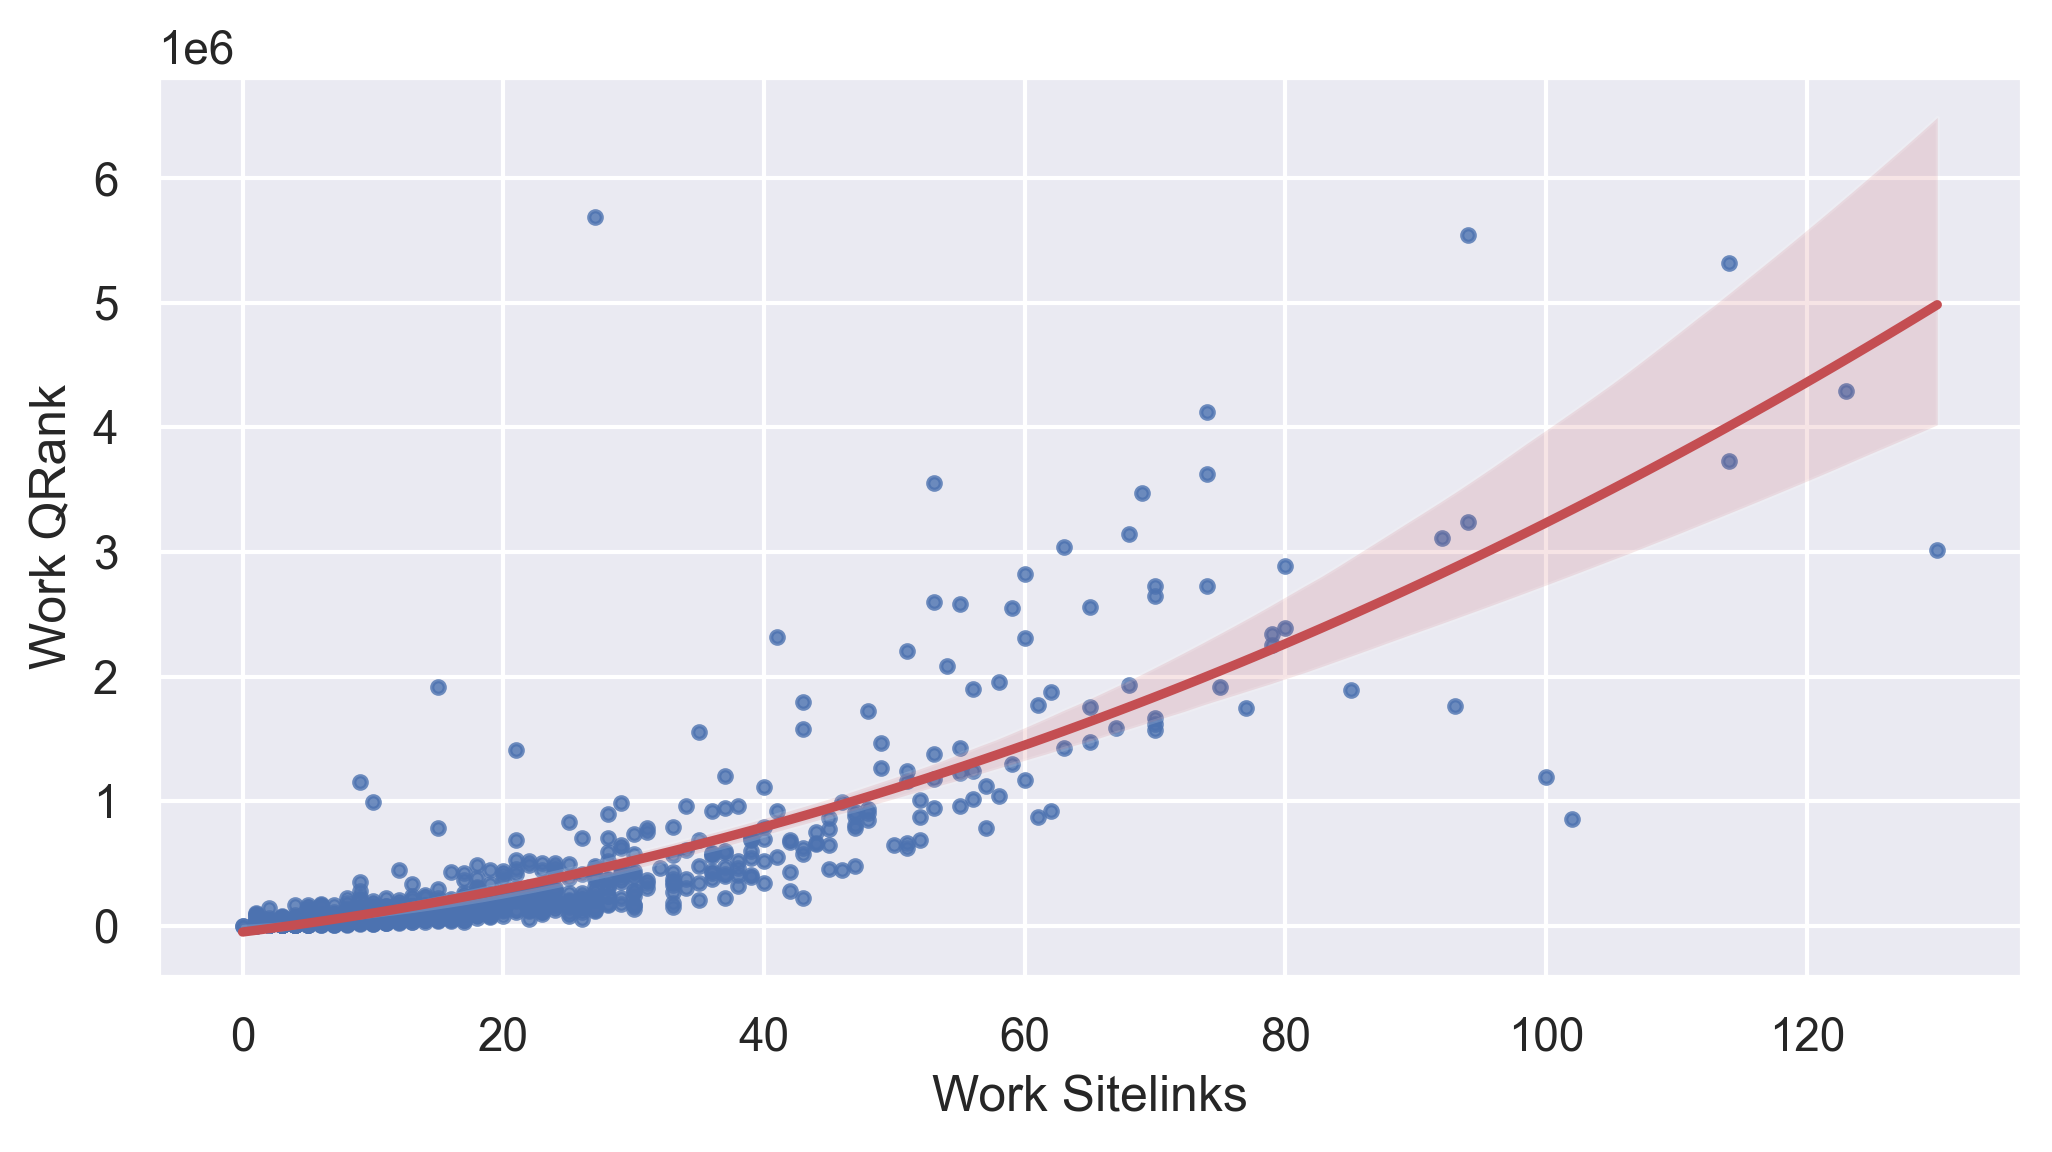

In [11]:
# Scatter plot of Work QRank and Work Sitelinks
plot_df = relevance_df.drop_nulls(["Work QRank", "Work Sitelinks"])
ax = sns.regplot(
    plot_df.to_pandas(),
    x="Work Sitelinks",
    y="Work QRank",
    marker=".",
    line_kws=dict(color="r"),
    order=2
)

print(f"n = {plot_df.height}")

n = 768


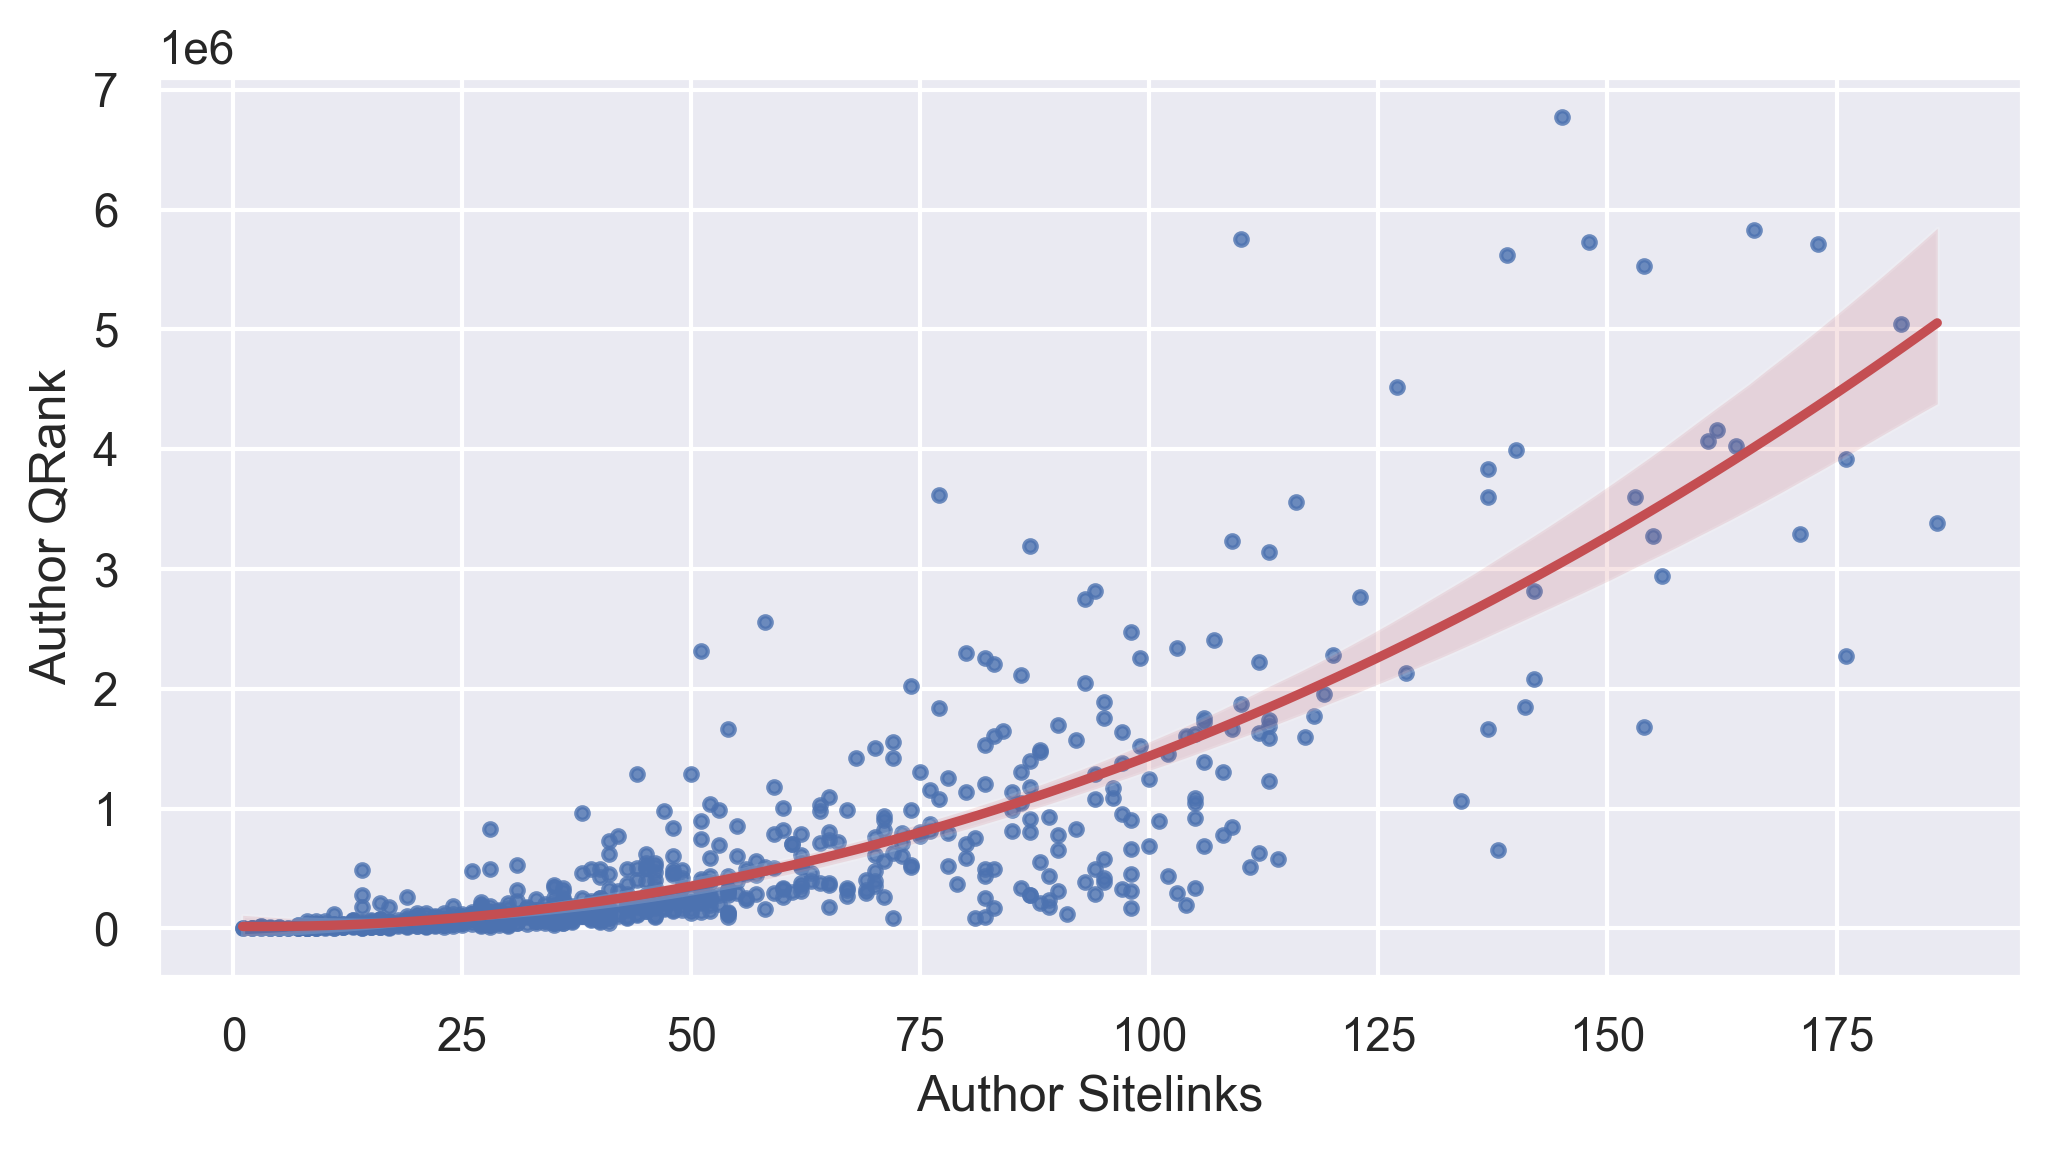

In [12]:
# Scatter plot of Author QRank and Author Sitelinks
plot_df = relevance_df.unique("Author Wikidata ID").drop_nulls(["Author QRank", "Author Sitelinks"])
ax = sns.regplot(
    plot_df.to_pandas(),
    x="Author Sitelinks",
    y="Author QRank",
    marker=".",
    line_kws=dict(color="r"),
    truncate=True,
    order=2,
)

# Print total cases
print(f"n = {plot_df.height}")